# Generating problem instances
This notebook is used to generate a set of problem instances for the traveling salesman problem with appointment scheduling (TSP-AS).
Per [Issue #47](https://github.com/leonlan/tsp-as/issues/47), we have to generate three types of instances:
1. Small toy instances, which are used to demonstrate examples of edge cases.
2. Medium sized instances, which are used to benchmark.
3. Large sized instances, to show the scalability of our approach.


## Literature
Following the paper by Zhan, Wang and Wan (2022) in EJOR, these are the most important points to mimic:
- Origin is located at (0, 0)
- Customers are located uniformly randomly on a [0, 50]^2 square.
- Travel time between two locations is equal to their Euclidean distance.
- Customer's mean service times $\mu$ are sampled from U(30, 60).
    - Uniform sampled from $U(0, \mu)$.
    - Normal, with $\sigma = 0.5\mu$.

Our `make_random` 

## Experimental setup
Factors and levels
- **Instance size**
    - small (5)
    - medium (15)
    - large (25)
- **Service times**
    - U(30, 60)
    - N(30, $\sigma$)
- **Omegas** (travel, idle, wait): 
    - 0.2/0.2/0.6
    - 0.6/0.2/0.2

## Small example
The code below generates a random instance, saves it as JSON, and loads the JSON as ProblemData instance.

In [139]:
import matplotlib.pyplot as plt

from tsp_as.classes import ProblemData, Solution
from tsp_as.plot import plot_instance

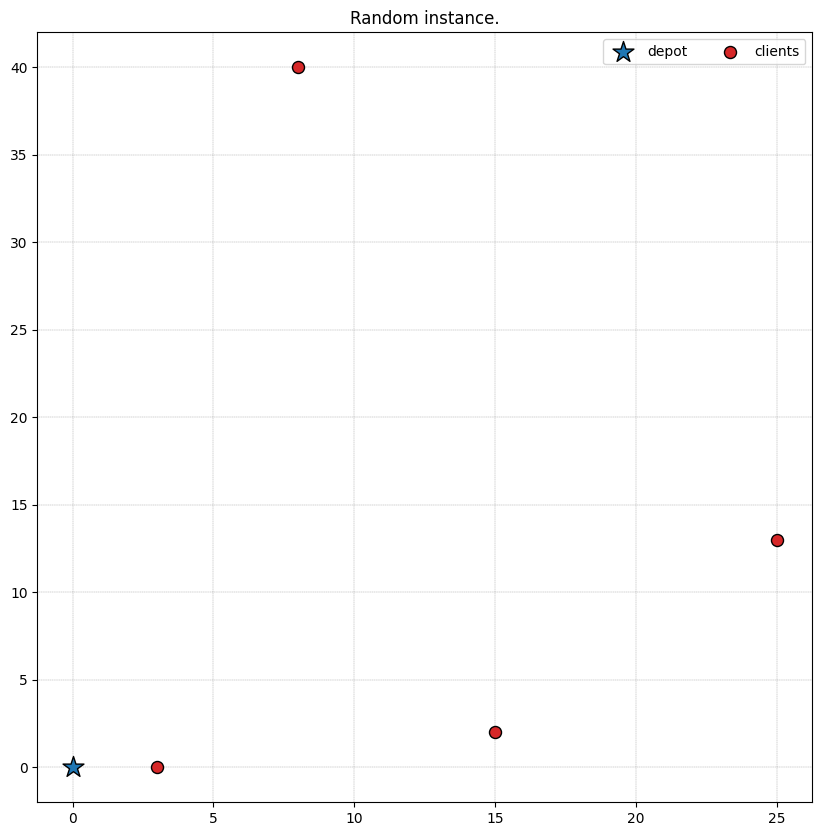

In [140]:
data = ProblemData.make_random(0, dim=5, max_size=50, max_service_time=20)
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
plot_instance(ax, data)

In [136]:
data_dict = {
    'coords': data.coords,
    'dimension': data.dimension,
    'distances': data.distances,
    'distances_scv': data.distances_scv,
    'service_scv': data.service_scv,
    'service': data.service,
}

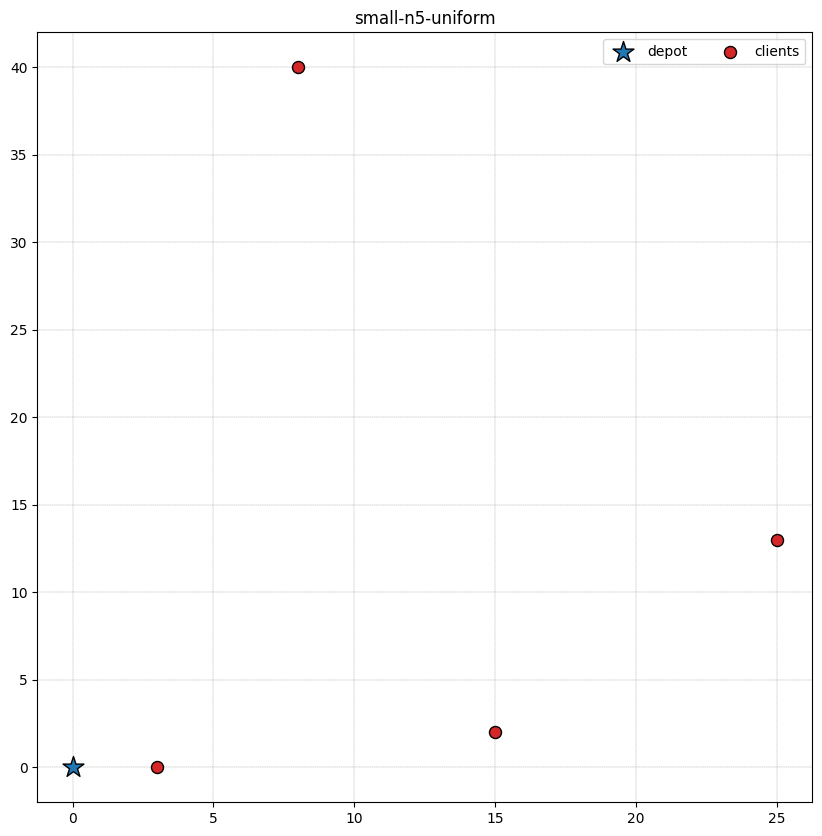

In [141]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return np.round(obj, 3).tolist()
        return json.JSONEncoder.default(self, obj)
    
tmp_path = '../tmp/small-n5-uniform.json'

with open(tmp_path, 'w', encoding='utf-8') as fh:
    json.dump(data_dict, fh, ensure_ascii=False, indent=4, cls=NumpyEncoder)
    
data = ProblemData.from_file(tmp_path)    
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
plot_instance(ax, data)